# Detecting Pneumonia Using Transfer Learning

In [159]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.python.keras import layers
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop
resnet_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline
from keras.applications.inception_v3 import InceptionV3
import cv2
import os
import skimage
from skimage.transform import resize
import numpy as np
from glob import glob
from os.path import isfile, join, abspath, exists, isdir, expanduser
from pathlib import Path
import pandas as pd
import seaborn as sns

## The Dataset

In [160]:
# Define path to the data directory
data_dir = Path('C:/Users/blindside/Desktop/Thinkful/TensorFlow')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,C:\Users\blindside\Desktop\Thinkful\TensorFlow...,1
1,C:\Users\blindside\Desktop\Thinkful\TensorFlow...,1
2,C:\Users\blindside\Desktop\Thinkful\TensorFlow...,1
3,C:\Users\blindside\Desktop\Thinkful\TensorFlow...,1
4,C:\Users\blindside\Desktop\Thinkful\TensorFlow...,1


# Exploring the Dataset 

1    3875
0    1341
Name: label, dtype: int64


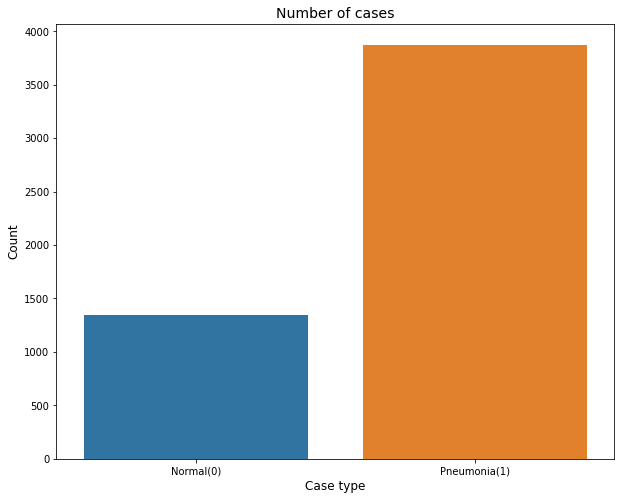

In [161]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

#### I have heard that it is not rare for medical datasets to have an imbalance for the disease and with this dataset there is nearly three times as many cases with pneumonia than without.  

In [148]:
pimages = os.listdir(train_dir + "PNEUMONIA")
nimages = os.listdir(train_dir + "NORMAL")

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


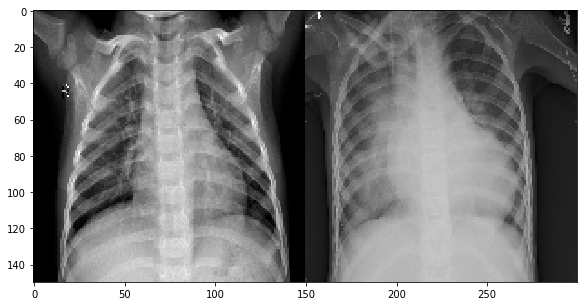

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


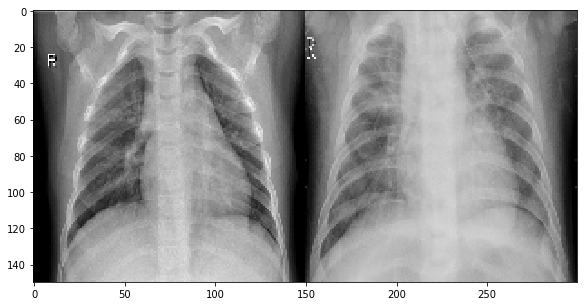

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


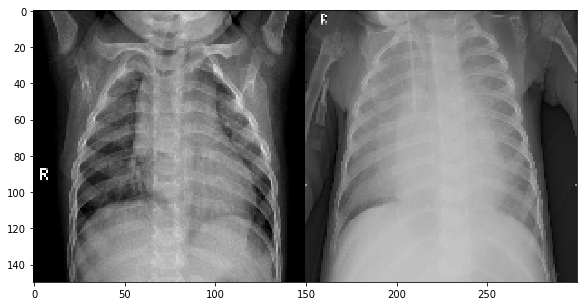

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


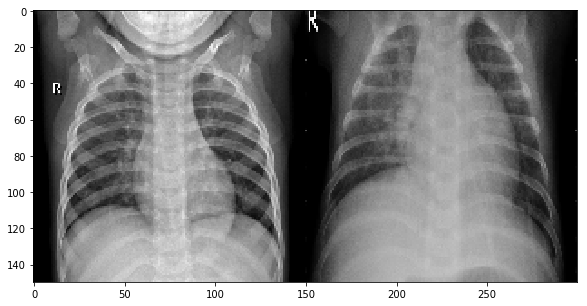

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


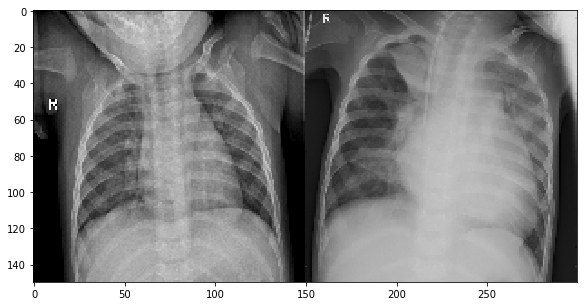

In [138]:
def plotter(i):
    imagep1 = cv2.imread(train_dir +"PNEUMONIA/"+pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(train_dir +"NORMAL/"+nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
    plotter(i)

## Pre-processing the images/ Transfer learning with Resnet50

In [2]:
batch_size = 128
num_classes = 2
image_size = 224

transfer_model = Sequential()
transfer_model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
transfer_model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
transfer_model.layers[0].trainable = False

In [4]:
transfer_model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

In [5]:
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        target_size=(image_size, image_size),
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        class_mode='categorical')

train_steps = train_generator.samples // batch_size
val_steps = validation_generator.samples // batch_size

img_input = layers.Input(shape=(image_size, image_size, 3))

epochs=125

history = transfer_model.fit_generator(train_generator,
        steps_per_epoch=train_steps,
        epochs = epochs,
        validation_data=validation_generator,
        validation_steps=val_steps)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/125
40/40 [==============================] - 92s 2s/step - loss: 0.2867 - acc: 0.8942 - val_loss: 0.6657 - val_acc: 0.6406
Epoch 2/125
40/40 [==============================] - 63s 2s/step - loss: 0.1778 - acc: 0.9384 - val_loss: 0.7422 - val_acc: 0.6484
Epoch 3/125
40/40 [==============================] - 64s 2s/step - loss: 0.1433 - acc: 0.9514 - val_loss: 0.7513 - val_acc: 0.6406
Epoch 4/125
40/40 [==============================] - 63s 2s/step - loss: 0.1270 - acc: 0.9568 - val_loss: 0.9143 - val_acc: 0.6250
Epoch 5/125
40/40 [==============================] - 63s 2s/step - loss: 0.1191 - acc: 0.9580 - val_loss: 1.0649 - val_acc: 0.6094
Epoch 6/125
40/40 [==============================] - 77s 2s/step - loss: 0.1091 - acc: 0.9643 - val_loss: 1.1829 - val_acc: 0.6016
Epoch 7/125
40/40 [==============================] - 66s 2s/step - loss: 0.1041 - acc: 0.9656 - val_loss: 1.3440 - val_acc: 0.5859


Epoch 124/125
40/40 [==============================] - 66s 2s/step - loss: 0.0306 - acc: 0.9919 - val_loss: 0.8206 - val_acc: 0.7656
Epoch 125/125
40/40 [==============================] - 65s 2s/step - loss: 0.0296 - acc: 0.9930 - val_loss: 0.7421 - val_acc: 0.7812


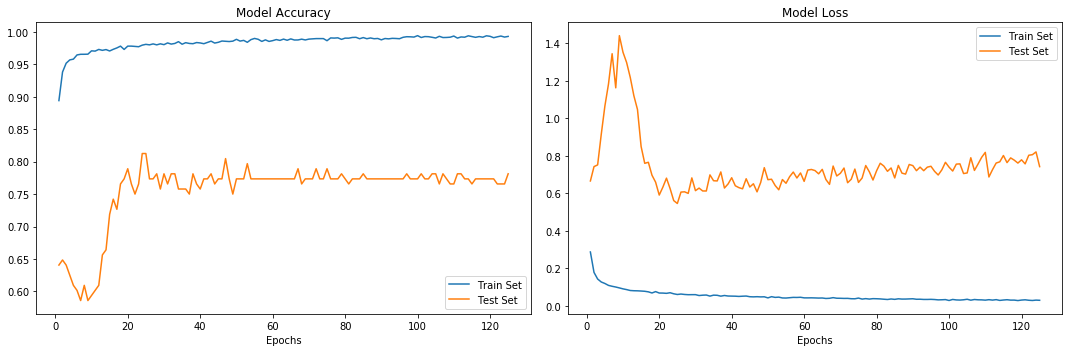

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(15,5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## transfer learning with ResNet50 with dropout

In [11]:
batch_size = 128
num_classes = 2
image_size = 224

transfer_model2 = Sequential()
transfer_model2.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
transfer_model2.add(Dropout(0.2))
transfer_model2.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
transfer_model2.layers[0].trainable = False
transfer_model2.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

In [12]:
history2 = transfer_model2.fit_generator(train_generator,
        steps_per_epoch=train_steps,
        epochs = epochs,
        validation_data=validation_generator,
        validation_steps=val_steps)

Epoch 1/125
40/40 [==============================] - 64s 2s/step - loss: 0.3411 - acc: 0.8583 - val_loss: 1.6467 - val_acc: 0.5625
Epoch 2/125
40/40 [==============================] - 62s 2s/step - loss: 0.1837 - acc: 0.9345 - val_loss: 1.6522 - val_acc: 0.5625
Epoch 3/125
40/40 [==============================] - 61s 2s/step - loss: 0.1487 - acc: 0.9426 - val_loss: 1.7222 - val_acc: 0.5625
Epoch 4/125
40/40 [==============================] - 62s 2s/step - loss: 0.1402 - acc: 0.9467 - val_loss: 1.7819 - val_acc: 0.5625
Epoch 5/125
40/40 [==============================] - 62s 2s/step - loss: 0.1254 - acc: 0.9553 - val_loss: 1.7172 - val_acc: 0.5625
Epoch 6/125
40/40 [==============================] - 62s 2s/step - loss: 0.1133 - acc: 0.9592 - val_loss: 1.8554 - val_acc: 0.5625
Epoch 7/125
40/40 [==============================] - 61s 2s/step - loss: 0.1103 - acc: 0.9614 - val_loss: 1.9524 - val_acc: 0.5625
Epoch 8/125
40/40 [==============================] - 62s 2s/step - loss: 0.1053 - a

40/40 [==============================] - 176s 4s/step - loss: 0.0371 - acc: 0.9893 - val_loss: 0.7530 - val_acc: 0.7812
Epoch 125/125
40/40 [==============================] - 180s 4s/step - loss: 0.0369 - acc: 0.9891 - val_loss: 0.8453 - val_acc: 0.7578


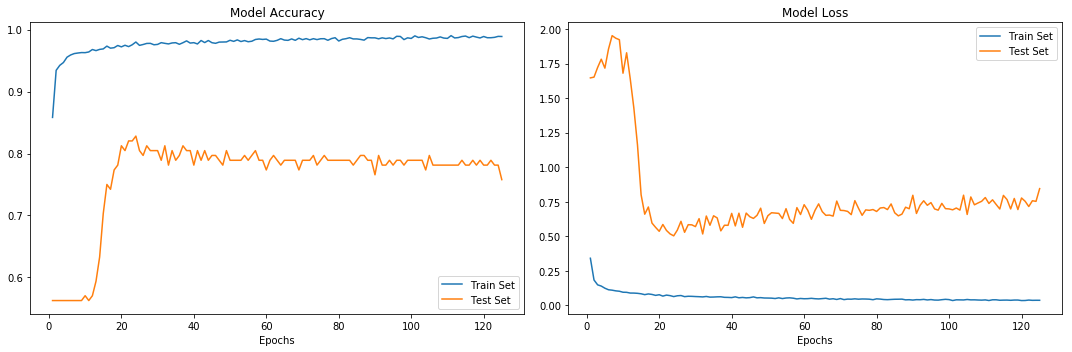

In [15]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(15,5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Transfer learning with ResNet50 with dropout and different optimizer

In [47]:
batch_size = 128
num_classes = 2
image_size = 224

transfer_model3 = Sequential()
transfer_model3.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
transfer_model3.add(Dropout(0.3))
transfer_model3.add(Dense(128, activation='relu'))
transfer_model3.add(BatchNormalization())                    
transfer_model3.add(Dense(num_classes, activation='sigmoid'))

# Say not to train first layer (ResNet) model. It is already trained
transfer_model3.layers[0].trainable = False
transfer_model3.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])

In [44]:
transfer_model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 23,850,754
Trainable params: 262,786
Non-trainable params: 23,587,968
_________________________________________________________________


In [48]:
history3 = transfer_model3.fit_generator(train_generator,
        steps_per_epoch=train_steps,
        epochs = 50,
        validation_data=validation_generator,
        validation_steps=val_steps)

Epoch 1/50
40/40 [==============================] - 159s 4s/step - loss: 0.4784 - acc: 0.7652 - val_loss: 0.7482 - val_acc: 0.5625
Epoch 2/50
40/40 [==============================] - 140s 4s/step - loss: 0.2763 - acc: 0.8740 - val_loss: 1.0659 - val_acc: 0.5625
Epoch 3/50
40/40 [==============================] - 141s 4s/step - loss: 0.2155 - acc: 0.8922 - val_loss: 1.1655 - val_acc: 0.5781
Epoch 4/50
40/40 [==============================] - 140s 3s/step - loss: 0.1885 - acc: 0.9006 - val_loss: 1.3502 - val_acc: 0.5938
Epoch 5/50
40/40 [==============================] - 140s 3s/step - loss: 0.1653 - acc: 0.9070 - val_loss: 1.4045 - val_acc: 0.5938
Epoch 6/50
40/40 [==============================] - 144s 4s/step - loss: 0.1471 - acc: 0.9184 - val_loss: 1.4623 - val_acc: 0.6016
Epoch 7/50
40/40 [==============================] - 141s 4s/step - loss: 0.1394 - acc: 0.9230 - val_loss: 1.5319 - val_acc: 0.5938
Epoch 8/50
40/40 [==============================] - 138s 3s/step - loss: 0.1257 - a

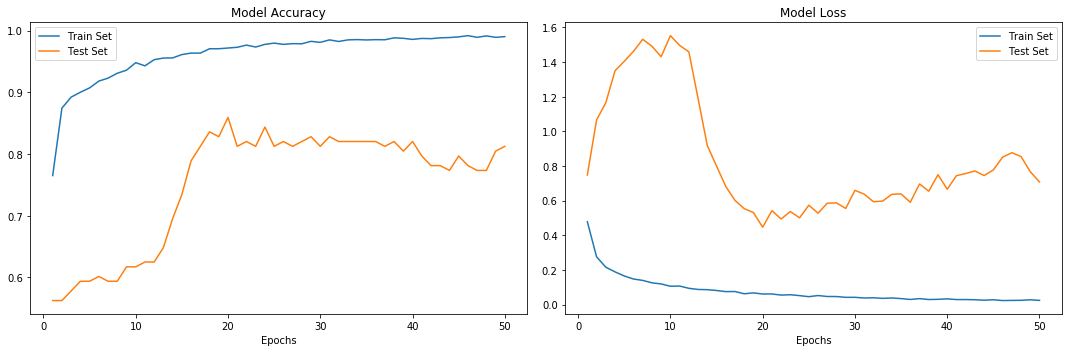

In [50]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs_range = range(1, 50 + 1)
plt.figure(figsize=(15,5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [88]:
transfer_model4 = Sequential()
transfer_model4.add(InceptionV3(weights=None, include_top=False, input_shape=(224, 224,3)))
transfer_model4.add(Dropout(0.3))
transfer_model4.add(GlobalAveragePooling2D())
transfer_model4.add(Dense(128, activation='relu'))
transfer_model4.add(BatchNormalization())
transfer_model4.add(Dense(2, activation='softmax'))

In [89]:
transfer_model4.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])

In [98]:
batch_size = 32
train_generator = data_generator.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        target_size=(image_size, image_size),
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        class_mode='categorical')

train_steps = train_generator.samples // batch_size
val_steps = validation_generator.samples // batch_size

img_input = layers.Input(shape=(image_size, image_size, 3))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [102]:
transfer_model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 5, 2048)        0         
_________________________________________________________________
global_average_pooling2d_21  (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               262272    
_________________________________________________________________
batch_normalization_1416 (Ba (None, 128)               512       
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 258       
Total params: 22,065,826
Trainable params: 22,031,138
Non-trainable params: 34,688
___________________________________________________________

In [100]:
history4 = transfer_model4.fit_generator(train_generator,
                              steps_per_epoch=train_steps,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=val_steps)

Epoch 1/50
163/163 [==============================] - 595s 4s/step - loss: 0.3784 - acc: 0.8750 - val_loss: 0.8419 - val_acc: 0.6266
Epoch 2/50
163/163 [==============================] - 509s 3s/step - loss: 0.2292 - acc: 0.9319 - val_loss: 1.2451 - val_acc: 0.6316
Epoch 3/50
163/163 [==============================] - 546s 3s/step - loss: 0.1405 - acc: 0.9486 - val_loss: 1.1675 - val_acc: 0.6530
Epoch 4/50
163/163 [==============================] - 512s 3s/step - loss: 0.1115 - acc: 0.9609 - val_loss: 1.0738 - val_acc: 0.6957
Epoch 5/50
163/163 [==============================] - 578s 4s/step - loss: 0.1132 - acc: 0.9607 - val_loss: 1.4810 - val_acc: 0.6711
Epoch 6/50
163/163 [==============================] - 543s 3s/step - loss: 0.0867 - acc: 0.9705 - val_loss: 1.0434 - val_acc: 0.6826
Epoch 7/50
163/163 [==============================] - 538s 3s/step - loss: 0.0768 - acc: 0.9741 - val_loss: 1.6187 - val_acc: 0.6776
Epoch 8/50
163/163 [==============================] - 561s 3s/step - 

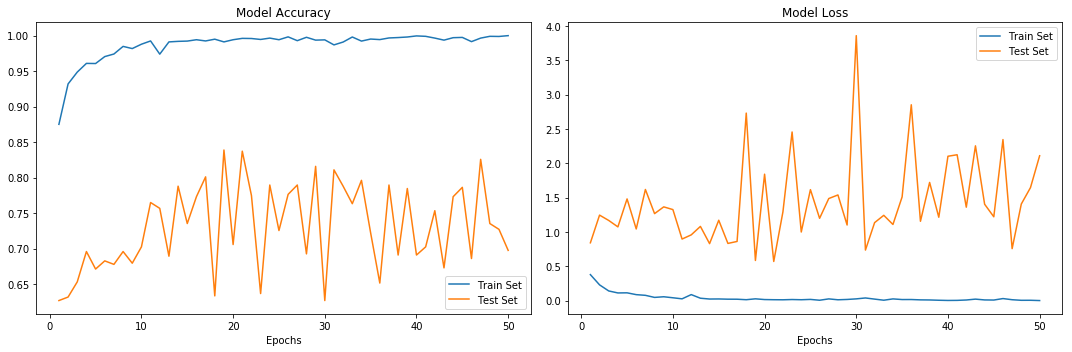

In [101]:
acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs_range = range(1, 50 + 1)
plt.figure(figsize=(15,5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Trainable turned on

In [162]:
batch_size = 4
num_classes = 2
image_size = 224
train_steps = train_generator.samples // batch_size
val_steps = validation_generator.samples // batch_size
img_input = layers.Input(shape=(image_size, image_size, 3))

In [117]:
train_generator = data_generator.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        target_size=(image_size, image_size),
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [106]:
transfer_model5 = Sequential()
transfer_model5.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
transfer_model5.add(Dropout(0.3))
transfer_model5.add(Dense(128, activation='relu'))
transfer_model5.add(BatchNormalization())                    
transfer_model5.add(Dense(num_classes, activation='sigmoid'))

# Lets try allowing the transfer model to be trained
transfer_model5.layers[0].trainable = True
transfer_model5.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])

In [118]:
history5 = transfer_model5.fit_generator(train_generator,
        steps_per_epoch=train_steps,
        epochs = 40,
        validation_data=validation_generator,
        validation_steps=val_steps)

Epoch 1/40
1304/1304 [==============================] - 1429s 1s/step - loss: 0.2739 - acc: 0.8470 - val_loss: 1.0375 - val_acc: 0.7699
Epoch 2/40
1304/1304 [==============================] - 1384s 1s/step - loss: 0.2059 - acc: 0.8742 - val_loss: 0.6072 - val_acc: 0.7740
Epoch 3/40
1304/1304 [==============================] - 1372s 1s/step - loss: 0.1814 - acc: 0.8771 - val_loss: 0.3201 - val_acc: 0.8922
Epoch 4/40
1304/1304 [==============================] - 1346s 1s/step - loss: 0.1856 - acc: 0.8794 - val_loss: 0.6731 - val_acc: 0.8115
Epoch 5/40
1304/1304 [==============================] - 1356s 1s/step - loss: 0.1693 - acc: 0.8855 - val_loss: 0.4315 - val_acc: 0.8611
Epoch 6/40
1304/1304 [==============================] - 1344s 1s/step - loss: 0.1795 - acc: 0.8783 - val_loss: 0.6704 - val_acc: 0.7865
Epoch 7/40
1304/1304 [==============================] - 1394s 1s/step - loss: 0.1690 - acc: 0.8832 - val_loss: 0.6412 - val_acc: 0.8031
Epoch 8/40
1304/1304 [==========================

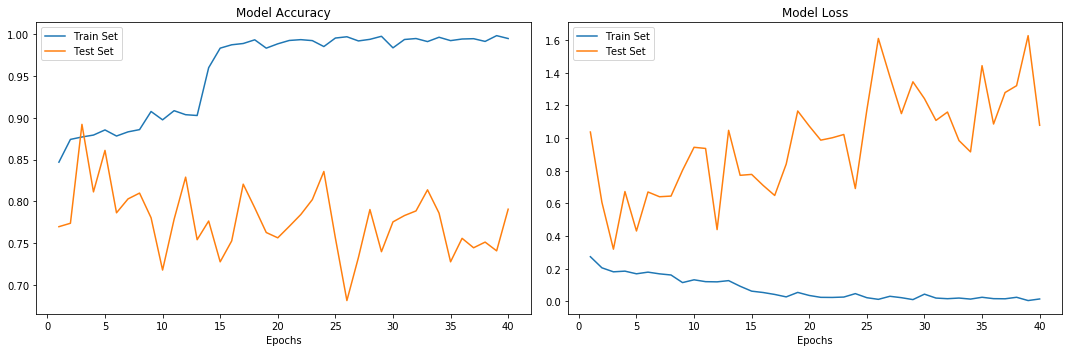

In [121]:
acc = history5.history['acc']
val_acc = history5.history['val_acc']
loss = history5.history['loss']
val_loss = history5.history['val_loss']
epochs_range = range(1, 40 + 1)
plt.figure(figsize=(15,5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

This model was where I purposefully turned training on, rather than turn it off as one would normally do for a pretrained model. I did this mostly because I wanted to see how much a difference it would make. This model was so much slower than the other because it trained 22 million parameters that normally wouldn't have been trained. This model reached its best test accuracy in the third epoch. In the future, if I choose to do this I will not use as many epochs the model showed to overfit more after a few epochs. In the end this model showed to have the best accuracy of my models.

In [123]:
batch_size = 128
num_classes = 2
image_size = 224
train_steps = train_generator.samples // batch_size
val_steps = validation_generator.samples // batch_size
img_input = layers.Input(shape=(image_size, image_size, 3))

In [125]:
transfer_model6 = Sequential()
transfer_model6.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
transfer_model6.add(Dropout(0.2))
transfer_model6.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
transfer_model6.layers[0].trainable = False
transfer_model6.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])

In [126]:
history6 = transfer_model6.fit_generator(train_generator,
        steps_per_epoch=train_steps,
        epochs = 50,
        validation_data=validation_generator,
        validation_steps=val_steps)

Epoch 1/50
40/40 [==============================] - 81s 2s/step - loss: 0.6243 - acc: 0.6875 - val_loss: 0.7064 - val_acc: 0.6250
Epoch 2/50
40/40 [==============================] - 11s 267ms/step - loss: 0.5687 - acc: 0.7063 - val_loss: 0.6287 - val_acc: 0.6953
Epoch 3/50
40/40 [==============================] - 11s 268ms/step - loss: 0.5065 - acc: 0.7437 - val_loss: 0.6063 - val_acc: 0.7188
Epoch 4/50
40/40 [==============================] - 11s 267ms/step - loss: 0.4397 - acc: 0.7750 - val_loss: 0.6199 - val_acc: 0.6797
Epoch 5/50
40/40 [==============================] - 11s 267ms/step - loss: 0.4430 - acc: 0.7938 - val_loss: 0.5903 - val_acc: 0.7188
Epoch 6/50
40/40 [==============================] - 11s 268ms/step - loss: 0.4039 - acc: 0.8500 - val_loss: 0.6526 - val_acc: 0.7031
Epoch 7/50
40/40 [==============================] - 11s 266ms/step - loss: 0.3666 - acc: 0.8250 - val_loss: 0.7042 - val_acc: 0.6797
Epoch 8/50
40/40 [==============================] - 11s 266ms/step - los

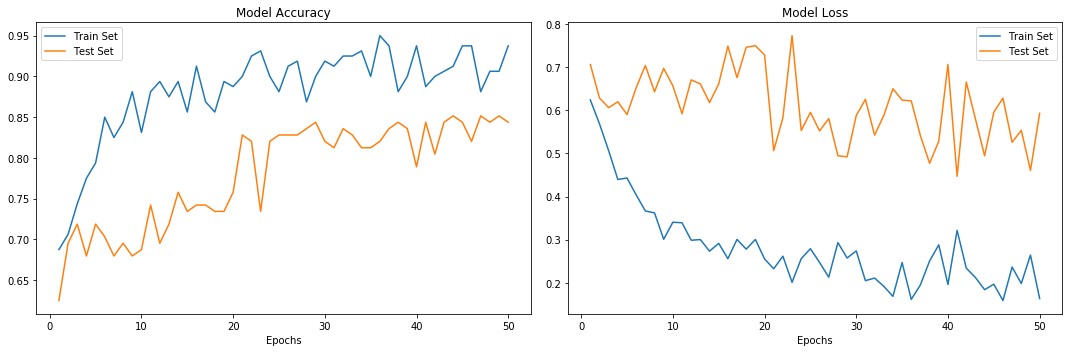

In [127]:
acc = history6.history['acc']
val_acc = history6.history['val_acc']
loss = history6.history['loss']
val_loss = history6.history['val_loss']
epochs_range = range(1, 50 + 1)
plt.figure(figsize=(15,5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Conclusion

This project was very much a learning journey for me. After finishing this project I can clearly see why deep learning is so popular and I am looking forward to doing more projects using Keras, I am growing like it quite a bit. In the end the best model I was able to create was the model ResNet50 model and retraining it with my data, this approach took much longer than a normal pretrained model. In the future, I will like to use more pretrained models and then retrain with fewer epochs. I wasted a lot of time using so many epochs. One of the problems I ran into with this project was with the overfitting, my belief is that this dataset was the culprit causing that issue. The dataset was too small to show better results, however I did find another dataset on Kaggle that is much bigger and I should have better results using that dataset when I use my best model from this project on the new dataset.